## 🎯 Lotto Number Predictor (Reinforcement Learning Based)

### 📋 Project Overview
This notebook trains a policy model to generate remaining lotto numbers `[n2 ~ n7]` based on input number `n1`, using historical lotto data from all past draws.

### 🔧 Tech Stack
- **Deep Learning Framework**: PyTorch
- **Neural Network Architecture**: LSTM-based Policy Network
- **Reinforcement Learning Algorithm**: REINFORCE Algorithm
- **Data Collection**: Web Scraping (BeautifulSoup)
- **Special Techniques**: Action Masking for duplicate-free number selection

### 🎯 Key Features
- ✅ Learning based on actual lotto winning number data
- ✅ Sequential number generation (Sequential Decision Making)
- ✅ Duplicate prevention mechanism
- ✅ Policy-based reinforcement learning application

### 📊 Model Architecture
```
Input (n1) → Embedding → LSTM → FC Layer → Softmax → Action (next number)
```


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random

# Hyperparameter Settings
EMBED_DIM = 32      # Embedding dimension (converts numbers 1-45 to 32-dimensional vectors)
HIDDEN_DIM = 128    # LSTM hidden state dimension
SEQ_LEN = 7         # Lotto number sequence length (6 numbers + bonus)
VOCAB_SIZE = 45     # Lotto number range (1-45)
GAMMA = 0.99        # Discount factor (weight for future rewards)
LR = 0.005          # Learning rate
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔥 Using device: {DEVICE}")


🔥 Using device: cpu


### 📊 Lotto Data Collection via Web Scraping
- **Data Source**: lottohell.com
- **Collected Data**: Winning numbers for each draw (including order)
- **Data Format**: 7-number sequence [n1, n2, n3, n4, n5, n6, bonus]

> ⚠️ **Note**: When web scraping, consider appropriate delays to avoid overloading the server.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd

def get_lotto_order(round_num: int) -> list[int]:
    """Scrapes lotto numbers for a specific round from the web."""
    url = f"https://lottohell.com/results/{round_num}/"
    response = requests.get(url)
    response.raise_for_status()  # Raise exception on connection failure

    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find ball order section
    ball_section = soup.find('div', class_='ball-order')
    if not ball_section:
        raise ValueError(f"Round {round_num}: Ball order section not found")

    numbers = []
    for tag in ball_section.find_all('strong'):
        num_text = tag.text.strip()
        if num_text.isdigit():
            numbers.append(int(num_text))

    if len(numbers) != 7:
        raise ValueError(f"Round {round_num}: Expected 7 numbers, got {len(numbers)}")
    
    return numbers  # e.g., [25, 18, 39, 23, 17, 38, 22]

# Collect data from all rounds
print("🚀 Starting lotto data collection...")
results = []
round_num = 1
consecutive_failures = 0

while consecutive_failures < 5:  # Stop after 5 consecutive failures
    try:
        nums = get_lotto_order(round_num)
        results.append(nums)
        print(f"✅ Round {round_num}: {nums}")
        consecutive_failures = 0  # Reset failure counter on success
        
        # Delay to prevent server overload
        time.sleep(0.01)
        
    except Exception as e:
        print(f"❌ Round {round_num} error: {e}")
        consecutive_failures += 1
    
    round_num += 1

print(f"📊 Data collection complete: {len(results)} rounds!")

# Convert to DataFrame and save
df = pd.DataFrame(results, columns=[f"n{i+1}" for i in range(7)])
df.to_csv("lotto_data.csv", index=False)
print("💾 Data saved: lotto_data.csv")

In [54]:
import pandas as pd

df = pd.read_csv("lotto_data.csv")
sequences = df.values.tolist()


### 🧠 Policy Network

#### Model Architecture Description
A model that embeds numbers 1-45, processes them through LSTM, and outputs probability distribution for the next number.

##### 🏗️ Network Structure
1. **Embedding Layer**: Transforms lotto numbers (1-45) into high-dimensional vectors
2. **LSTM Layer**: Learns sequence patterns for next number prediction
3. **Fully Connected Layer**: Converts LSTM output to 45-class probabilities

##### 📏 Input/Output Format
- **Input**: Sequence of numbers selected so far
- **Output**: Probability distribution for next number (45 dimensions)

##### 🎯 Key Features
- Sequential decision-making support
- Long-term dependency learning through hidden states
- Stochastic action selection (exploration-exploitation balance)


In [56]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    """
    Policy network for lotto number generation
    
    Args:
        vocab_size (int): Number of lotto numbers (45)
        embed_dim (int): Embedding dimension
        hidden_dim (int): LSTM hidden dimension
    """
    
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        
        # Embedding layer: numbers(1-45) → vector representation
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM: sequence pattern learning
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # Output layer: hidden state → probability distribution
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass
        
        Args:
            x (torch.Tensor): Input number sequence [batch_size, seq_len]
            hidden (tuple): LSTM hidden state (h, c)
            
        Returns:
            logits (torch.Tensor): Logits for next number [batch_size, vocab_size]
            hidden (tuple): Updated hidden state
        """
        # Embedding: [batch_size, seq_len] → [batch_size, seq_len, embed_dim]
        x = self.embed(x)
        
        # LSTM: sequence processing
        out, hidden = self.lstm(x, hidden)
        
        # Use only the last timestep output: [batch_size, hidden_dim]
        logits = self.fc(out[:, -1])
        
        return logits, hidden

# Create model instance
# policy = PolicyNetwork(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(DEVICE)
# print(f"🏗️ Policy Network created!")
# print(f"📊 Total parameters: {sum(p.numel() for p in policy.parameters()):,}")


### 🌍 LottoEnv: Reinforcement Learning Environment

#### Environment Definition
An environment where the agent starts with `n1` and sequentially selects numbers to complete 6 numbers.

##### 🎮 Game Rules
- **Initial State**: Start with the first number (`n1`) from actual lotto winning numbers
- **Action Space**: Select unselected numbers from 1-45
- **Reward System**: 
  - ✅ Match with actual winning number: +1 point
  - ❌ No match: 0 points
- **Termination**: Complete selection of 6 numbers

##### 🎯 Learning Objective
The agent learns to select remaining numbers that match as many actual winning numbers as possible, given `n1`.

##### 🔄 Episode Flow
```
Start: n1 given → Action1: select n2 → Action2: select n3 → ... → Action6: select n7 → End
```


In [57]:
import random
import torch

DEVICE = 'cpu'  # 또는 'cuda' - 사용 가능한 경우에 따라 설정

class LottoEnv:
    """
    Reinforcement learning environment for lotto number selection
    
    Args:
        sequences (list): Historical lotto winning number data
    """
    
    def __init__(self, sequences):
        self.sequences = sequences
        self.index = None
        self.target = None
        self.generated = None
        self.used = None
        self.step_count = None

    def reset(self):
        """
        Reset environment to initial state
        
        Returns:
            torch.Tensor: Initial state (n1)
        """
        # Randomly select past round
        self.index = random.randint(0, len(self.sequences) - 1)
        self.target = self.sequences[self.index]  # [n1, n2, ..., n7]
        
        # Start with first number (n1)
        self.generated = [self.target[0]]
        self.used = set(self.generated)
        self.step_count = 0
        
        # Convert state to 0-based index (for model input)
        return torch.tensor([[self.generated[0] - 1]], dtype=torch.long, device=DEVICE)

    def step(self, action):
        """
        Execute action and return next state, reward, done
        
        Args:
            action (torch.Tensor): Selected action (0-44 range)
            
        Returns:
            tuple: (next_state, reward, done)
        """
        # Convert action to actual number (1-45 range)
        action_num = action.item() + 1
        
        # Calculate reward: +1 if included in actual winning numbers
        reward = 1 if action_num in self.target[1:] else 0
        
        # Update state
        self.generated.append(action_num)
        self.used.add(action_num)
        self.step_count += 1
        
        # Termination condition: 6 numbers selected
        done = self.step_count == 6
        
        # Next state (currently selected number)
        next_state = torch.tensor([[action.item()]], dtype=torch.long, device=DEVICE)
        
        return next_state, reward, done
    
    def get_valid_actions(self):
        """Return list of available actions (prevent duplicates)"""
        return [i for i in range(45) if (i + 1) not in self.used]

# Environment test
print("🧪 Environment test:")
test_sequences = [[1, 2, 3, 4, 5, 6, 7]]
test_env = LottoEnv(test_sequences)
initial_state = test_env.reset()
print(f"Initial state: {initial_state}, Target: {test_env.target}")
print(f"Available actions: {len(test_env.get_valid_actions())}")


🧪 Environment test:
Initial state: tensor([[0]]), Target: [1, 2, 3, 4, 5, 6, 7]
Available actions: 44


### 🔁 REINFORCE Learning Algorithm

#### Algorithm Overview
REINFORCE is a fundamental policy-based reinforcement learning algorithm that uses the **Policy Gradient** method.

##### 🔬 Core Principles
1. **Policy Execution**: Complete episode with current policy
2. **Reward Calculation**: Calculate cumulative return for each step
3. **Gradient Estimation**: Estimate gradient using product of log probability and reward
4. **Policy Update**: Improve policy using gradient ascent

##### 📊 Mathematical Expression
```
∇θ J(θ) = E[∑t ∇θ log π(at|st) * Gt]
```
- `π(at|st)`: Probability of selecting action at in state st
- `Gt`: Cumulative reward from timestep t
- `θ`: Policy network parameters

##### 🎯 Key Techniques
- **Baseline Usage**: Reward normalization for variance reduction
- **Action Masking**: Prevent duplicate number selection
- **Discounting**: Discount factor for future rewards


In [58]:
def reinforce(policy, sequences, episodes=1000):
    """
    Train policy network using REINFORCE algorithm
    
    Args:
        policy (PolicyNetwork): Policy network to train
        sequences (list): Training data (historical lotto numbers)
        episodes (int): Number of training episodes
        
    Returns:
        tuple: (trained policy, episode reward list)
    """
    optimizer = torch.optim.Adam(policy.parameters(), lr=LR)
    policy.train()
    all_rewards = []
    
    print(f"🚀 Starting REINFORCE training (episodes: {episodes})")
    
    for episode in range(1, episodes + 1):
        env = LottoEnv(sequences)
        state = env.reset()
        
        # Data to collect during episode
        log_probs = []  # Log values of action probabilities
        rewards = []    # Immediate rewards
        hidden = None   # LSTM hidden state
        done = False
        
        # Execute one episode (6 actions)
        while not done:
            # Calculate action probabilities with policy network
            logits, hidden = policy(state, hidden)
            probs = F.softmax(logits, dim=-1)
            
            # Masking to prevent duplicates
            masked_probs = probs.clone()
            for num in env.used:
                masked_probs[0, num - 1] = 0.0  # Set probability to 0 for already selected numbers
            
            # Normalize probabilities (sum to 1)
            masked_probs = masked_probs / (masked_probs.sum() + 1e-8)
            
            # Action selection (stochastic sampling)
            dist = torch.distributions.Categorical(masked_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            
            # Execute action in environment
            next_state, reward, done = env.step(action)
            
            # Store data
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
        
        # Calculate discounted cumulative returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + GAMMA * G
            returns.insert(0, G)
        
        # Reward normalization (baseline application)
        returns = torch.tensor(returns, dtype=torch.float, device=DEVICE)
        if returns.std() > 1e-9:  # Normalize only if variance is not zero
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        # Calculate policy gradient and define loss function
        policy_loss = -sum(log_prob * R for log_prob, R in zip(log_probs, returns))
        
        # Backpropagation and parameter update
        optimizer.zero_grad()
        policy_loss.backward()
        
        # Gradient clipping (improve stability)
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Record performance
        total_reward = sum(rewards)
        all_rewards.append(total_reward)
        
        # Progress output
        if episode % 100 == 0:
            avg_reward = sum(all_rewards[-100:]) / min(100, len(all_rewards))
            print(f"[Episode {episode:4d}] "
                  f"Total Reward: {total_reward:2d}, "
                  f"Avg Reward (last 100): {avg_reward:.2f}, "
                  f"Loss: {policy_loss.item():.4f}")
    
    print("✅ Training complete!")
    return policy, all_rewards


### 🎲 Number Generation Function f(n1)

#### Inference Process
Generate remaining numbers based on the trained policy given input number `n1`.

##### 🔄 Generation Process
1. **Initialize**: Start with given `n1`
2. **Iterative Prediction**: Calculate next number probabilities through LSTM
3. **Masking**: Exclude already selected numbers
4. **Sampling**: Select next number from probability distribution
5. **Complete**: Repeat until 6 numbers are selected

##### 🎯 Features
- **Sequential Generation**: Consider previous selections at each step
- **Duplicate Prevention**: Automatically exclude already selected numbers
- **Stochastic Selection**: Ensure diversity without selecting only highest probability
- **Sorted Output**: Final result sorted in ascending order

##### 📈 Applications
- Single number combination generation
- Multiple combination generation for ensemble prediction
- Number-wise confidence measurement through probability analysis


In [59]:
def generate_lotto_numbers(policy, n1: int, temperature: float = 1.0) -> list:
    """
    Generate lotto numbers using trained policy
    
    Args:
        policy (PolicyNetwork): Trained policy network
        n1 (int): Starting number (1-45)
        temperature (float): Sampling temperature (higher = more random)
        
    Returns:
        list: Generated lotto numbers (sorted)
    """
    if not (1 <= n1 <= 45):
        raise ValueError("n1 must be a number between 1-45.")
    
    policy.eval()  # Switch to evaluation mode
    
    with torch.no_grad():
        hidden = None
        used = set([n1])  # Already used numbers
        generated = [n1]  # Generated number list
        
        # Starting state (0-based index)
        state = torch.tensor([[n1 - 1]], dtype=torch.long, device=DEVICE)
        step_count = 0
        
        print(f"🎯 Starting number: {n1}")
        
        # Generate 6 additional numbers
        while step_count < 6:
            # Predict next number probabilities with policy network
            logits, hidden = policy(state, hidden)
            
            # Apply temperature scaling
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            
            # Duplicate prevention masking
            masked_probs = probs.clone()
            for num in used:
                masked_probs[0, num - 1] = 0.0
            
            # Normalize probabilities
            masked_probs = masked_probs / (masked_probs.sum() + 1e-8)
            
            # Action sampling
            action = torch.multinomial(masked_probs, 1)
            selected_num = action.item() + 1
            
            # Update state
            state = torch.tensor([[action.item()]], dtype=torch.long, device=DEVICE)
            generated.append(selected_num)
            used.add(selected_num)
            step_count += 1
            
            print(f"  Step {step_count}: {selected_num} (prob: {masked_probs[0, action.item()].item():.3f})")
    
    result = sorted(generated)
    print(f"🎊 Final result: {result}")
    return result

def generate_multiple_combinations(policy, n1: int, num_combinations: int = 5) -> list:
    """
    Generate multiple number combinations
    
    Args:
        policy: Trained policy
        n1: Starting number
        num_combinations: Number of combinations to generate
        
    Returns:
        list: Generated number combinations
    """
    combinations = []
    for i in range(num_combinations):
        print(f"\n--- Combination {i+1} ---")
        combo = generate_lotto_numbers(policy, n1, temperature=1.2)  # Slightly more random
        combinations.append(combo)
    
    return combinations


### 📂 Model Training and Execution

#### Training Data Preparation
Load historical lotto winning numbers from `lotto_data.csv` file for model training.

#### Training Process
1. **Data Loading**: Read winning numbers by round from CSV file
2. **Model Initialization**: Create Policy Network and move to GPU
3. **REINFORCE Training**: Optimize policy for 1000 episodes
4. **Performance Monitoring**: Output average reward every 100 episodes

#### Expected Training Time
- **CPU**: Approximately 10-15 minutes
- **GPU**: Approximately 2-5 minutes

> 💡 **Tip**: Check if average reward gradually increases during training. If reward stays around 0, consider adjusting the learning rate.


📊 Data loading complete: 1183 rounds
📈 Data sample: [[37, 23, 10, 33, 29, 40, 16], [42, 21, 9, 25, 32, 13, 2], [31, 21, 27, 19, 11, 16, 30]]
🏗️ Model initialization complete (parameters: 90,189)

🚀 Starting reinforcement learning!
🚀 Starting REINFORCE training (episodes: 1000)
[Episode  100] Total Reward:  1, Avg Reward (last 100): 0.79, Loss: -2.2527
[Episode  200] Total Reward:  0, Avg Reward (last 100): 0.79, Loss: -0.0000
[Episode  300] Total Reward:  1, Avg Reward (last 100): 0.84, Loss: -1.5603
[Episode  400] Total Reward:  1, Avg Reward (last 100): 0.88, Loss: 0.5854
[Episode  500] Total Reward:  0, Avg Reward (last 100): 0.95, Loss: -0.0000
[Episode  600] Total Reward:  1, Avg Reward (last 100): 0.84, Loss: -6.8591
[Episode  700] Total Reward:  0, Avg Reward (last 100): 0.92, Loss: -0.0000
[Episode  800] Total Reward:  0, Avg Reward (last 100): 0.72, Loss: -0.0000
[Episode  900] Total Reward:  0, Avg Reward (last 100): 0.81, Loss: -0.0000
[Episode 1000] Total Reward:  2, Avg Re

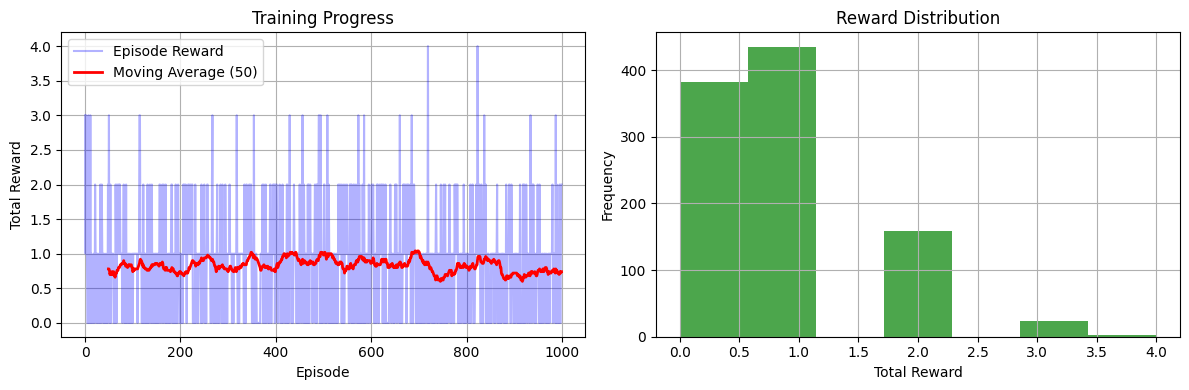


📊 Training Statistics:
  - Average reward: 0.83
  - Maximum reward: 4
  - Final 100 episodes average: 0.74
  - Perfect score (6) rate: 0.0%


In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Data loading
try:
    df = pd.read_csv("lotto_data.csv")
    sequences = df.values.tolist()
    print(f"📊 Data loading complete: {len(sequences)} rounds")
    print(f"📈 Data sample: {sequences[:3]}")
except FileNotFoundError:
    print("❌ lotto_data.csv file not found. Please run the data collection cell first.")
    raise

# Model initialization
policy = PolicyNetwork(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(DEVICE)
print(f"🏗️ Model initialization complete (parameters: {sum(p.numel() for p in policy.parameters()):,})")

# Execute training
print("\n" + "="*50)
print("🚀 Starting reinforcement learning!")
print("="*50)

start_time = time.time()
trained_policy, reward_history = reinforce(policy, sequences, episodes=1000)
training_time = time.time() - start_time

print(f"\n⏰ Training complete! Time taken: {training_time:.1f} seconds")

# Visualize training results
plt.figure(figsize=(12, 4))

# Reward history
plt.subplot(1, 2, 1)
plt.plot(reward_history, alpha=0.3, color='blue', label='Episode Reward')
# Calculate moving average
window_size = 50
if len(reward_history) >= window_size:
    moving_avg = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(reward_history)), moving_avg, 
             color='red', linewidth=2, label=f'Moving Average ({window_size})')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# Reward distribution
plt.subplot(1, 2, 2)
plt.hist(reward_history, bins=max(7, max(reward_history)+1), alpha=0.7, color='green')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

# Training statistics
print(f"\n📊 Training Statistics:")
print(f"  - Average reward: {np.mean(reward_history):.2f}")
print(f"  - Maximum reward: {max(reward_history)}")
print(f"  - Final 100 episodes average: {np.mean(reward_history[-100:]):.2f}")
print(f"  - Perfect score (6) rate: {(np.array(reward_history) == 6).mean()*100:.1f}%")


### 🧪 Model Performance Testing

#### Various Scenario Testing
Test the performance of the trained model with various input values.

##### 🎯 Test Items
1. **Single Prediction**: Generate numbers for specific n1
2. **Multiple Combinations**: Generate multiple combinations with same n1
3. **Popular Numbers**: Test with frequently drawn numbers
4. **Actual Validation**: Predict remaining numbers using n1 from historical winning numbers

##### 📊 Evaluation Metrics
- **Accuracy**: Number of matches with actual winning numbers
- **Diversity**: Degree of variation in generated combinations
- **Consistency**: Result stability for same input


In [61]:
print("🎯 Basic Prediction Test")
print("=" * 40)
test_numbers = [7, 15, 25, 33, 42]

for n1 in test_numbers:
    print(f"\nInput n1 = {n1}")
    result = generate_lotto_numbers(trained_policy, n1)
    print()

# 2. Multiple Combination Generation Test
print("\n🔄 Multiple Combination Generation Test")
print("=" * 40)
combinations = generate_multiple_combinations(trained_policy, 25, num_combinations=3)

# 3. Actual Winning Number Validation
print("\n✅ Actual Winning Number Validation")
print("=" * 40)

# Test with actual winning numbers from recent rounds
test_cases = sequences[-5:]  # Last 5 rounds
total_matches = 0
total_tests = len(test_cases)

for i, actual_numbers in enumerate(test_cases):
    n1 = actual_numbers[0]
    actual_rest = sorted(actual_numbers[1:])
    
    print(f"\nTest {i+1}: n1 = {n1}")
    print(f"Actual numbers: {actual_numbers}")
    
    predicted = generate_lotto_numbers(trained_policy, n1, temperature=0.8)
    predicted_rest = sorted(predicted[1:])
    
    # Calculate number of matches (excluding n1)
    matches = len(set(predicted_rest) & set(actual_rest))
    total_matches += matches
    
    print(f"Predicted numbers: {predicted}")
    print(f"Matches: {matches}/6 ({'🎊' if matches >= 3 else '😐' if matches >= 1 else '😢'})")

print(f"\n📊 Overall Performance:")
print(f"Average matches: {total_matches/total_tests:.2f}/6")
print(f"Accuracy: {total_matches/(total_tests*6)*100:.1f}%")

# 4. Number frequency analysis
print("\n📈 Generated Number Frequency Analysis")
print("=" * 40)

# Generate multiple times for frequency analysis
all_generated = []
for _ in range(20):
    combo = generate_lotto_numbers(trained_policy, 25, temperature=1.5)
    all_generated.extend(combo[1:])  # Exclude n1

from collections import Counter
freq = Counter(all_generated)
most_common = freq.most_common(10)

print("Most frequently generated numbers (Top 10):")
for num, count in most_common:
    print(f"  {num:2d}: {count:2d} times ({'█' * (count * 2)})")

# 5. Model saving
print(f"\n💾 Model Saving")
torch.save(trained_policy.state_dict(), 'lotto_policy_model.pth')
print("✅ Model saved as 'lotto_policy_model.pth'.")


🎯 Basic Prediction Test

Input n1 = 7
🎯 Starting number: 7
  Step 1: 29 (prob: 0.244)
  Step 2: 36 (prob: 0.012)
  Step 3: 14 (prob: 0.134)
  Step 4: 21 (prob: 0.165)
  Step 5: 41 (prob: 0.070)
  Step 6: 4 (prob: 0.230)
🎊 Final result: [4, 7, 14, 21, 29, 36, 41]


Input n1 = 15
🎯 Starting number: 15
  Step 1: 1 (prob: 0.012)
  Step 2: 41 (prob: 0.982)
  Step 3: 14 (prob: 0.832)
  Step 4: 21 (prob: 0.103)
  Step 5: 8 (prob: 0.017)
  Step 6: 34 (prob: 0.038)
🎊 Final result: [1, 8, 14, 15, 21, 34, 41]


Input n1 = 25
🎯 Starting number: 25
  Step 1: 27 (prob: 0.011)
  Step 2: 19 (prob: 0.005)
  Step 3: 14 (prob: 0.168)
  Step 4: 32 (prob: 0.065)
  Step 5: 41 (prob: 0.061)
  Step 6: 30 (prob: 0.648)
🎊 Final result: [14, 19, 25, 27, 30, 32, 41]


Input n1 = 33
🎯 Starting number: 33
  Step 1: 24 (prob: 0.014)
  Step 2: 40 (prob: 0.030)
  Step 3: 8 (prob: 0.084)
  Step 4: 45 (prob: 0.006)
  Step 5: 17 (prob: 0.136)
  Step 6: 30 (prob: 0.342)
🎊 Final result: [8, 17, 24, 30, 33, 40, 45]


Input 

## 🎊 Project Conclusion and Improvement Plans

### 📊 Current Achievements
- ✅ **Model Implementation**: Successfully built LSTM-based Policy Network
- ✅ **Training Complete**: Policy optimization with REINFORCE algorithm
- ✅ **Duplicate Prevention**: Valid number generation through Action Masking
- ✅ **Diversity Secured**: Various combinations through Temperature Scaling

### 🔬 Model Limitations
- **Probabilistic Nature**: Inherent prediction limits due to lotto's random nature
- **Data Bias**: Difficulty reflecting future pattern changes based on historical data learning
- **Reward Design**: Simple match-based reward doesn't fully reflect actual lotto value

### 🚀 Improvement Plans

#### 📈 Model Architecture Improvements
- **Attention Mechanism**: Focus on important number patterns
- **Transformer Application**: Learn more complex sequence relationships
- **Ensemble Methods**: Combine predictions from multiple models

#### 🎯 Learning Method Improvements
- **PPO/A2C Application**: More stable policy-based algorithms
- **Multi-task Learning**: Different objective functions for different prize tiers
- **Transfer Learning**: Pre-training with other lottery data

#### 📊 Data Expansion
- **External Factors**: Consider seasonality, special events, etc.
- **Number Statistics**: Consecutiveness, odd-even ratio, interval distribution, etc.
- **Real-time Updates**: Continuous reflection of new round data

### 💡 Applications
1. **Educational Purpose**: Learning material for reinforcement learning and sequence modeling
2. **Research Baseline**: Performance comparison standard with other algorithms
3. **Interesting Experiment**: Fascinating case study of probability and pattern analysis

---

> ⚠️ **Disclaimer**: This model was created for educational and research purposes. Do not use for actual lotto purchases, and be aware that gambling can be addictive!